In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas_datareader import data
from datetime import datetime
from numpy.linalg import inv
from scipy.stats import normaltest
from scipy.stats import kurtosis

from sklearn.linear_model import HuberRegressor,LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from skpp import ProjectionPursuitRegressor

import MyHuberLoss

from joblib import Parallel, delayed
import multiprocessing

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


In [2]:
x_month = pd.read_csv('data/8-agg-factors.csv').dropna().drop(columns='Data')
y_month = pd.read_csv('data/131-macrodat.csv',header = None)

## Functions defined for use

In [3]:
from sklearn.model_selection import KFold

def mse(data, pred):
    return(sum(data - pred)**2/len(data))

def in_sample_cv(X,y,model,cv = 5):
    kf = KFold(n_splits=cv,random_state=0)
    mse_cv = list()
    for train, _ in kf.split(X):
        mse_pred = mse(y[train],model.fit(X.iloc[train],y[train]).predict(X.iloc[train]))
        mse_cv.append(mse_pred)
    return(np.mean(mse_cv))

def out_sample_cv(X,y,model,cv = 5):
    kf = KFold(n_splits=cv,random_state=0)
    mse_cv = list()
    for train, test in kf.split(X):
        mse_pred = mse(y[test],model.fit(X.iloc[train],y[train]).predict(X.iloc[test]))
        mse_cv.append(mse_pred)
    return(np.mean(mse_cv))





In [4]:
def out_sample_cv_parallel(X,y,model,cv = 5):
    kf = KFold(n_splits=cv,random_state=0)
    
    def pred(train,test):
        return(mse(y[test],model.fit(X.iloc[train],y[train]).predict(X.iloc[test])))
    
    num_cores = multiprocessing.cpu_count()
    mse_cv = Parallel(n_jobs=5)(delayed(pred)(train,test) for train,test in kf.split(X))
    return(np.mean(mse_cv))



In [5]:
def fourier_basis(series,k):
    N = len(series)
    # t from 1 to N
    t = np.linspace(1,N,N)
    out_list = list()
    for index in range(1,k+1):
        # derieve numerial result of ai, bi (intergration) for fourier basis
        cosxfx = np.cos(2*index*t*np.pi/N)*np.array(series)
        sinxfx = np.sin(2*index*t*np.pi/N)*np.array(series)
        ai = 2/N*sum(cosxfx - cosxfx[0]/2 - cosxfx[-1]/2)
        bi = 2/N*sum(sinxfx - sinxfx[0]/2 - sinxfx[-1]/2)
        basis_i = ai*np.cos(2*np.pi*index*t/N)+bi*np.sin(2*np.pi*index*t/N)
        out_list.append(basis_i)
    return(out_list)

def polynomial_basis(series,k):
    out_list = list()
    for index in range(1,k+1):
        out_list.append(series**index)
    return(out_list)

def basis_transform(X,model = polynomial_basis,k = 5):
    temp = X.apply(model,axis = 0, k = k)
    out = np.array([i for i in temp]).reshape(k*X.shape[1],X.shape[0]).transpose()
    return(pd.DataFrame(out))

In [6]:
def grid_cv(X, y, sample_method = out_sample_cv, model=None, basis = None, alpha_list = -1, J_list = -1, cv = 5):
    # the method is only use for SPCA model (alpha,J) and SPCA-LS model (J), not for PCA model and LS model
    if type(alpha_list) in {int, float}:
        alpha_list = [alpha_list]
    if type(J_list) in {int, float}:
        J_list = [J_list]
        
    if alpha_list != [-1] and J_list != [-1]:
        # case for scpa model
        res = pd.DataFrame([[a,J] for a in alpha_list for J in J_list],columns=['alpha','J'])
    
        final_par,final_loss = res.iloc[0,:],-1
        for item in range(res.shape[0]):
            X_expand = basis_transform(X, k = res.iloc[item,1])
            run_model = model(sigma = res.iloc[item,0],fit_intercept = False)

            loss = 0
            for i in range(y.shape[1]):
                yi = y[i]
                loss += sample_method(X_expand,yi,run_model,cv)
            if final_loss < 0 or final_loss > loss:
                final_par,final_loss = res.iloc[item,:],loss
    elif alpha_list == [-1]:
        # case for spca-ls model (model = sklearn.linearRegression)
        res = pd.DataFrame(J_list, columns=['J'])
        
        final_par,final_loss = res.iloc[0,:],-1
        for item in range(res.shape[0]):
            X_expand = basis_transform(X, k=res.iloc[item,0])
            run_model = model(fit_intercept = False)

            loss = 0
            for i in range(y.shape[1]):
                yi = y[i]
                loss += sample_method(X_expand,yi,run_model,cv)
            if final_loss < 0 or final_loss > loss:
                final_par,final_loss = res.iloc[item,:],loss
    else:
        final_par = -1
    return(final_par)

In [7]:
N = 131
T = 480
C_list = [i/50 for i in range(1,5)] + [i/10 for i in range(1,11)] + [i for i in range(2,6)]
alpha_list = [np.sqrt(T/np.log(N*T))*C for C in C_list]
J_list = [i+1 for i in range(6)]

In [8]:
x_month.shape
y_month.shape
pd.DataFrame(x_month[240:480]).reset_index()

,index,F1,F2,F3,F4,F5,F6,F7,F8
0,240,-0.694602,0.010622,0.305187,0.244695,-0.163255,0.198857,0.101344,0.079756
1,241,-0.605469,-0.116519,-0.142423,0.100263,-0.020608,-0.368652,0.191678,-0.002403
2,242,-0.409218,0.020962,-0.158319,-0.168234,0.169056,-0.122685,0.000924,-0.221226
3,243,-0.445416,-0.077201,-0.070987,-0.090584,0.109874,-0.142151,0.025854,0.100558
4,244,-0.403030,0.031000,-0.129042,-0.275598,0.357499,-0.205591,-0.097363,0.156813
...,...,...,...,...,...,...,...,...,...
235,475,0.012119,-0.013741,0.152269,-0.029489,0.433522,-0.151863,0.074537,-0.002530
236,476,-0.134700,0.129094,0.041514,0.183898,0.215773,0.128569,-0.060284,-0.245117
237,477,-0.098441,0.172306,-0.175540,0.276649,0.188795,-0.234770,-0.107363,-0.434911
238,478,-0.253172,0.136358,0.163368,0.139089,0.203435,0.045756,0.146176,-0.257954


In [9]:
# par_out = grid_cv(x_month,y_month[1],out_sample_cv,MyHuberLoss.HuberRegressor,\
#         polynomial_basis,[0.1,0.2],3)
X_df,Y_df = pd.DataFrame(x_month[239:479]).reset_index().drop(columns='index'),pd.DataFrame(y_month[239:479]).reset_index().drop(columns='index')
par_out_spca = grid_cv(X_df,Y_df,out_sample_cv_parallel,MyHuberLoss.HuberRegressor,polynomial_basis,alpha_list,J_list)

## Use parameters generated by cross validation to form model

In [10]:
def augmented_factor_spca(y=None,obs_factors=None,alpha=1,J=1,start=0,end=None):
    # y is a pd.DataFrame with samples at row and features at column
    # obs_facotors is a pd.DataFrame with samples at row and features at column
    X = basis_transform(obs_factors,k=J)
    def robust_fit(y):
        return(MyHuberLoss.HuberRegressor(sigma=alpha,fit_intercept=False)\
               .fit(X.iloc[start:end,:], y).predict(X.iloc[start:end,:]))
    
    origin_y = y.iloc[start:end,:]
    pred_robust_df = origin_y.apply(robust_fit)
    pred_sigma = pred_robust_df.cov()

    K,N= obs_factors.shape[1] , origin_y.shape[1]
    T = origin_y.shape[0]
    
    pred_lambda= PCA(n_components=K,whiten=True).fit(pred_robust_df).components_*(N**0.5)
    pred_g = np.matmul(np.array(pred_robust_df),pred_lambda.transpose())/N
    pred_f = np.matmul(np.array(origin_y),pred_lambda.transpose())/N
    pred_gamma = pred_f - pred_g
    
    res_dict = {'lambda': pred_lambda, 'g':pred_g , 'f': pred_f, 'gamma': pred_gamma}
    return(res_dict)

In [11]:
kurt_raw = Y_df.apply(kurtosis,axis=0,fisher = False)

In [20]:
obs_factors = X_df
X = basis_transform(obs_factors,k=int(par_out_spca['J']))
def robust_fit(y):
    return(MyHuberLoss.HuberRegressor(sigma=par_out_spca['alpha'],fit_intercept=False).fit(X, y).predict(X))

In [21]:
pred_y = Y_df.apply(robust_fit)

In [22]:
kurt_new = pd.DataFrame(pred_y).apply(kurtosis,axis=0,fisher = False)

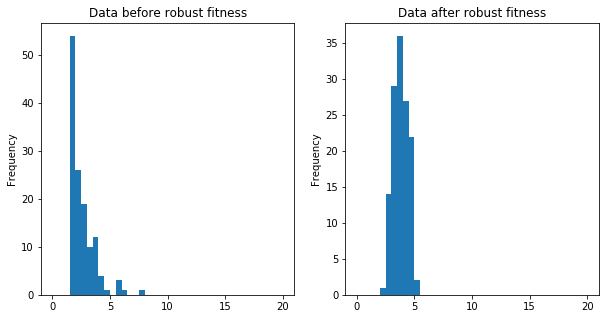

In [45]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(kurt_raw,range = [0,20],bins=40)
plt.title('Data before robust fitness')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(kurt_new,range = [0,20],bins=40)
plt.title('Data after robust fitness')
plt.ylabel('Frequency')
plt.savefig('pic/Figure6_2.png')
plt.show()